### Description：
> 在上一个版本的基础上，想做一些改进：
>> 从上面的模型中的结果可以发现，XGB的效果比较好，首先，再回忆一遍处理过程：
>>> * 获取数据集，我已经通过预处理保存到了data1.csv里面
>>> * 切割出要压缩的特征进行自编码压缩
>>> * 然后合并数据，并进行标准化
>>> * 按照机器学习的步骤进行训练，测试
>>
> 结果发现，XGB能把所有的正确样本识别出来，但是错误的样本也就是异常的样本识别效果不理想，猜测的可能原因有如下几个：
>> * 1. 数据不平衡问题，正样本是与负样本的比例是100：1，这可能导致模型没法学习到有用的异常样本的特征
>> * 2. 自编码压缩那块， 由于没有压缩特征之前是2929维， 压缩成了5维的深度，并且由于机器的问题，迭代训练的次数太少，损失还没有降下来，导致可能很多有用特征的信息损失掉了
>
>所以，在这个笔记本中，尝试改进：
>> * 首先是数据不平衡问题， 尝试采用过采样的方式，增加负样本的个数，采用直接复制，然后组合成一个样本集，再随机打乱。
>> * 至于自编码压缩那块，先不动，因为电脑跑不动目前。

In [1]:
"""导入包"""
import numpy as np
import pandas as pd
from sklearn.utils import shuffle      # 随机打乱dataframe的行排序

from keras.models import Model #泛型模型
from keras.layers import Dense, Input
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# 模型选择
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

# 模型
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# 模型度量函数
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
"""导入数据"""
data = pd.read_csv("data1.csv")

In [3]:
"""处理缺失值，先采用简单的0填充"""
data = data.fillna(0)

# print(data.isnull().sum())
print(data.shape)            
data.head(5)

(22902, 2929)


,time,latitude,longitude,instrument,temperature0.0,temperature20.0,temperature250.0,temperature70.0,temperature140.0,temperature155.0,...,salinity1516.0,temperature1036.0,salinity1036.0,temperature863.0,salinity863.0,temperature943.0,salinity943.0,temperature967.0,salinity967.0,label
0,23806.38,1.200,139.100,1,29.9,30.0,0.0,28.8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,23806.42,1.783,137.500,1,30.1,30.1,0.0,29.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,23806.50,1.883,137.867,1,28.9,28.9,0.0,27.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,23806.58,2.083,137.300,1,29.0,29.0,0.0,28.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,23806.67,2.283,137.183,1,28.9,28.9,0.0,26.7,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [4]:
#### """查看一下数据类型，把instrument转换成LabelEncoder编码"""
# print(data.dtypes)
tran = data['instrument']
tran = tran.astype(np.string_)
data['instrument'] = tran

le = preprocessing.LabelEncoder()
le.fit(data['instrument'].unique())
data['instrument'] = le.transform(data['instrument'])
# print(data['instrument'])
print(data['instrument'].value_counts())

8    12840
1     3347
5     2395
0     1670
3     1654
7      477
2      372
4      108
9       34
6        5
Name: instrument, dtype: int64


In [5]:
"""在这块先解决一下数据严重不平衡问题"""
# 查看一下data[label]，看一下正负样本的比列
print("正负样本的个数：")
print(data['label'].value_counts())   

# 尝试重新增加负样本的个数，然后重新组合data
trueSample = data[data['label'] == 1]
falseSample = data[data['label'] == 0]

print(trueSample.shape)
print(falseSample.shape)

temp = falseSample.copy()
for i in range(60):
    falseSample = pd.concat([falseSample, temp], axis=0)

print(falseSample.shape)

正负样本的个数：
1    22620
0      282
Name: label, dtype: int64
(22620, 2929)
(282, 2929)
(17202, 2929)


In [6]:
data = pd.concat([trueSample, falseSample], axis=0)
data = shuffle(data)
print(data.shape)
data['label'].value_counts()

(39822, 2929)


1    22620
0    17202
Name: label, dtype: int64

In [7]:
"""查看data的数据类型，并且要进行编码器和解码器压缩特征"""
data.dtypes
data.head(5)

# 提取出sub_data，保存需哟啊的特征
sub_data = data.iloc[:, 0:4].copy()
sub_data = pd.concat([sub_data, data['label']], axis=1)
# 获取需要压缩的列
deep = data.iloc[:, 4:-1].copy()

In [8]:
value = deep.values
print(value.shape)

(39822, 2924)


In [9]:
"""把数据进行标准化"""
scaler = StandardScaler()
values = scaler.fit_transform(value)

In [10]:
"""自编码器模型"""

# 压缩特征维度至2维
encoding_dim = 5
 
# this is our input placeholder
input_data = Input(shape=(2924,))
 
# 编码层
encoded = Dense(128, activation='relu')(input_data)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)
 
# 解码层
decoded = Dense(10, activation='relu')(encoder_output)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(2924, activation='tanh')(decoded)
 
# 构建自编码模型
autoencoder = Model(inputs=input_data, outputs=decoded)
 
# 构建编码模型
encoder = Model(inputs=input_data, outputs=encoder_output)
 
# compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
 
# training
autoencoder.fit(values, values, epochs=50, batch_size=256, shuffle=True)


Epoch 1/50
39822/39822 [==============================] - 10s 254us/step - loss: 0.8463
Epoch 2/50
39822/39822 [==============================] - 10s 245us/step - loss: 0.7994
Epoch 3/50
39822/39822 [==============================] - 9s 238us/step - loss: 0.7898
Epoch 4/50
39822/39822 [==============================] - 9s 232us/step - loss: 0.7834
Epoch 5/50
39822/39822 [==============================] - 9s 232us/step - loss: 0.7816
Epoch 6/50
39822/39822 [==============================] - 9s 230us/step - loss: 0.7800
Epoch 7/50
39822/39822 [==============================] - 9s 232us/step - loss: 0.7786
Epoch 8/50
39822/39822 [==============================] - 9s 230us/step - loss: 0.7773
Epoch 9/50
39822/39822 [==============================] - 9s 232us/step - loss: 0.7760
Epoch 10/50
39822/39822 [==============================] - 9s 233us/step - loss: 0.7765
Epoch 11/50
39822/39822 [==============================] - 9s 233us/step - loss: 0.7755
Epoch 12/50
39822/39822 [==============

In [11]:
# plotting
encoded_data = encoder.predict(values)
print(encoded_data.shape)

(39822, 5)


In [12]:
# new_feature_data = pd.DataFrame(encoded_data, columns = ['deep1', 'deep2'])
sub_data1 = pd.DataFrame(encoded_data, columns=['deep'+ str(i) for i in range(encoding_dim)])
print(sub_data1.shape)

print(sub_data.shape)

(39822, 5)
(39822, 5)


In [13]:
"""下面进行数据的合并"""
sub_data = sub_data.reset_index(drop= True)
sub_data1 = sub_data1.reset_index(drop= True)        # 由于之前随机打乱了行数据，需要进行索引重建才可以后面的合并列

newdata = pd.concat([sub_data, sub_data1], axis=1)
print(newdata.shape)

(39822, 10)


In [14]:
"""查看newdata"""
newdata.head(5)

,time,latitude,longitude,instrument,label,deep0,deep1,deep2,deep3,deep4
0,33034.04,8.000,137.500,1,0,10.970567,9.830492,21.860441,5.438149,-27.673203
1,37311.00,7.833,136.483,8,1,6.717964,-3.232464,-0.380005,-2.153029,-1.987084
2,35182.00,5.000,136.983,8,1,8.947531,-1.715774,0.864107,-0.941965,-3.536172
3,31972.25,4.967,132.367,5,0,-21.048632,-32.846874,5.398369,-4.202077,10.855045
4,33033.50,8.000,132.467,3,1,-16.586191,-11.120455,-6.275790,19.120222,-12.384036


In [15]:
# 标准化前三列的数据
newdata.iloc[:,0:3] = scaler.fit_transform(newdata.iloc[:, 0:3])

In [16]:
newdata.head(5)

,time,latitude,longitude,instrument,label,deep0,deep1,deep2,deep3,deep4
0,-0.295965,1.089847,0.587218,1,0,10.970567,9.830492,21.860441,5.438149,-27.673203
1,0.874059,1.031729,0.217826,8,1,6.717964,-3.232464,-0.380005,-2.153029,-1.987084
2,0.291640,0.045818,0.399434,8,1,8.947531,-1.715774,0.864107,-0.941965,-3.536172
3,-0.586433,0.034334,-1.277178,5,0,-21.048632,-32.846874,5.398369,-4.202077,10.855045
4,-0.296113,1.089847,-1.240856,3,1,-16.586191,-11.120455,-6.275790,19.120222,-12.384036


###  创建数据集和模型
> 通过上面的处理，就有了成形的数据，下面就是创建数据集和模型，然后进行选择

In [27]:
"""获取数据集，并且分出测试集"""
X = newdata.drop(['label'], axis=1).values
Y = newdata['label'].values

print(X.shape)
print(Y.shape)
print(data['label'].value_counts())

"""由于不匹配，所有分割数据集的时候采用层次抽样的方式"""
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)

for train_index, test_index in ss.split(X, Y):
    print(train_index, test_index)
    train_set_x = X[train_index]
    train_set_y = Y[train_index]
    test_set_x = X[test_index]
    test_set_y = Y[test_index]

(39822, 9)
(39822,)
1    22620
0    17202
Name: label, dtype: int64
[16515  8219  5994 ... 25091 18000 30742] [22963 33603  8580 ... 26820   221 23034]


In [28]:
print(train_set_x.shape)
print(train_set_y.shape)
print(test_set_x.shape)
print(test_set_y.shape)


(31857, 9)
(31857,)
(7965, 9)
(7965,)


KNN: 0.987 (0.002)
SVM: 0.982 (0.002)
Ada: 0.885 (0.006)
Xgb: 0.906 (0.006)


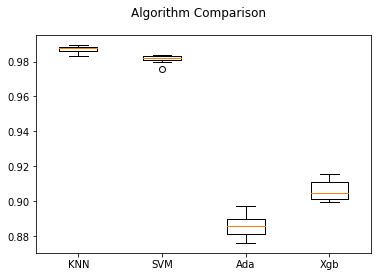

In [29]:
"""创建各种模型"""
num_folds = 10
seed = 7

kfold = KFold(n_splits=num_folds, random_state=seed)
models = {}
# models['LR'] = LogisticRegression()
models['KNN'] = KNeighborsClassifier()
# models['CART'] = DecisionTreeClassifier()
models['SVM'] = SVC()
#models['NB'] = GaussianNB()
models['Ada'] = AdaBoostClassifier()
# models['Xgb'] = XGBClassifier(learning_rate=0.1,
#                               n_estimators=1000,         # 树的个数--1000棵树建立xgboostmax_depth=6,              
#                               max_depth=6,               # 树的深度
#                               min_child_weight = 1,      # 叶子节点最小权重
#                               gamma=0.,                  # 惩罚项中叶子结点个数前的参数
#                               subsample=0.8,             # 随机选择80%样本建立决策树
#                               colsample_btree=0.8,       # 随机选择80%特征建立决策树
#                               scale_pos_weight=1,        # 解决样本个数不平衡的问题
#                               random_state=27            # 随机数)
#                              )
models['Xgb'] = XGBClassifier()
results = []

for name in models:
    result = cross_val_score(models[name], train_set_x, train_set_y, cv=kfold)
    results.append(result)
    msg = ('%s: %.3f (%.3f)' % (name, result.mean(), result.std()))
    print(msg)
    
# 图表展示
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(models.keys())
plt.show()    

In [30]:
"""优化模型 - KNN调参"""
# 调参改进算法 --- KNN
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(X=train_set_x, y=train_set_y)

print('最优: %s 使用 %s' % (grid_result.best_score_, grid_result.best_params_))
cv_results = zip(grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score'], grid_result.cv_results_['params'])

for mean, std, param in cv_results:
    print('%f (%f) with %r' % (mean, std, param)) 

最优: 0.9950089462284584 使用 {'n_neighbors': 1}
0.995009 (0.001212) with {'n_neighbors': 1}
0.990928 (0.001664) with {'n_neighbors': 3}
0.987130 (0.001753) with {'n_neighbors': 5}
0.983834 (0.002517) with {'n_neighbors': 7}
0.980664 (0.002304) with {'n_neighbors': 9}
0.977368 (0.002514) with {'n_neighbors': 11}
0.974134 (0.002555) with {'n_neighbors': 13}
0.970776 (0.002490) with {'n_neighbors': 15}
0.967794 (0.003181) with {'n_neighbors': 17}
0.964686 (0.003542) with {'n_neighbors': 19}
0.962143 (0.003726) with {'n_neighbors': 21}


In [ ]:
"""优化模型 - SVM调参"""
# 支持向量机有两个重要的参数：  C（惩罚系数）默认1.0 和kernel（径向基函数） 默认rbf
param_grid = {}
param_grid['C'] = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
#param_grid['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
# 注意： 这里的kernel参数不要有precomputed  , 否则会报错
"""
ValueError: X should be a square kernel matrix

    解决：从参数空间中删除“预先计算”.
        kernel =’precomputed’只能在传递表示样本的成对相似性的(n_samples,n_samples)数据矩阵时使用,
        而不是传统的(n_samples,n_features)矩形数据矩阵.
"""

model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(X=train_set_x, y=train_set_y)

print('最优： %s 使用 %s' % (grid_result.best_score_, grid_result.best_params_))
cv_results = zip(grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score'], grid_result.cv_results_['params'])
for mean, std, param in cv_results:
    print('%f (%f) with %r' % (mean, std, param))

In [23]:
"""AdaBoost调参"""
param_grid = {'n_estimators': [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900]}

model = AdaBoostClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(X=train_set_x, y=train_set_y)

print('最优： %s 使用 %s' % (grid_result.best_score_, grid_result.best_params_))

cv_results = zip(grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score'], grid_result.cv_results_['params'])
for mean, std, param in cv_results:
    print('%f (%f) with %r' % (mean, std, param))

最优： 0.9883739970525627 使用 {'n_estimators': 10}
0.988374 (0.002827) with {'n_estimators': 10}
0.988319 (0.002870) with {'n_estimators': 50}
0.988101 (0.002835) with {'n_estimators': 100}
0.987992 (0.002675) with {'n_estimators': 200}
0.987937 (0.002385) with {'n_estimators': 300}
0.987992 (0.002303) with {'n_estimators': 400}
0.987774 (0.002492) with {'n_estimators': 500}
0.987664 (0.002655) with {'n_estimators': 600}
0.987664 (0.003042) with {'n_estimators': 700}
0.987774 (0.002786) with {'n_estimators': 800}
0.987774 (0.002586) with {'n_estimators': 900}


###  确定最终的模型

In [33]:
# model =XGBClassifier(learning_rate=0.1,
#                      n_estimators=1000,         # 树的个数--1000棵树建立xgboostmax_depth=6,              
#                      max_depth=6,               # 树的深度
#                      min_child_weight = 1,      # 叶子节点最小权重
#                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
#                      subsample=0.8,             # 随机选择80%样本建立决策树
#                      colsample_btree=0.8,       # 随机选择80%特征建立决策树
#                      scale_pos_weight=1,        # 解决样本个数不平衡的问题
#                      random_state=27            # 随机数)
#                     )

#model = AdaBoostClassifier(n_estimators=10)
model = KNeighborsClassifier(n_neighbors=1)
#model = XGBClassifier()

model.fit(X=train_set_x, y=train_set_y)

# 评估模型
predictions = model.predict(test_set_x)
print("accuracy_score\n",accuracy_score(test_set_y, predictions))
print("\nconfusion_matrix\n", pd.DataFrame(confusion_matrix(test_set_y, predictions),columns=np.unique(test_set_y), index=np.unique(test_set_y)))
print("\nclassification_report\n", classification_report(test_set_y, predictions))

accuracy_score
 0.9962335216572504

confusion_matrix
       0     1
0  3441     0
1    30  4494

classification_report
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3441
           1       1.00      0.99      1.00      4524

    accuracy                           1.00      7965
   macro avg       1.00      1.00      1.00      7965
weighted avg       1.00      1.00      1.00      7965

